In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import os

In [2]:
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Bidirectional, TimeDistributed

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
import gensim.models.keyedvectors as word2vec
from gensim.models import KeyedVectors

word2vec_path = "C:\\Word2Vec_Models\\word2vec_tr"
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [4]:
# read the dataset
df = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [5]:
df.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [6]:
len(df.columns)

25

In [7]:
df = df.drop([df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4],df.columns[5],
             df.columns[6],df.columns[7],df.columns[8],df.columns[9],df.columns[10],
             df.columns[11],df.columns[12],df.columns[13],df.columns[14],df.columns[15],df.columns[16],
             df.columns[17],df.columns[18],df.columns[19],df.columns[20],df.columns[22]], axis='columns')

In [8]:
df.head()

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [9]:
def prepare_word_tag_list(ser):
    sentence_list = []
    tag_list = []
    
    for i in range(len(ser)):
        sentence_list.append(ser.iloc[i,1])
        tag_list.append(ser.iloc[i,2])
    
    return sentence_list, tag_list

In [10]:
dataset = df.groupby(['sentence_idx']).apply(prepare_word_tag_list)

In [11]:
dataset.head()

sentence_idx
1.0    ([Thousands, of, demonstrators, have, marched,...
2.0    ([Families, of, soldiers, killed, in, the, con...
3.0    ([They, marched, from, the, Houses, of, Parlia...
4.0    ([Police, put, the, number, of, marchers, at, ...
5.0    ([The, protest, comes, on, the, eve, of, the, ...
dtype: object

In [12]:
dataset.shape

(35177,)

In [13]:
# get words
dataset.iloc[1547][0]

['More',
 'than',
 '160',
 'people',
 'have',
 'died',
 'from',
 'bird',
 'flu',
 'since',
 'late',
 '2003',
 '.',
 'More',
 'than',
 '160',
 'people',
 'have',
 'died',
 'from',
 'bird',
 'flu',
 'since',
 'late',
 '2003',
 '.']

In [14]:
# get tags
dataset.iloc[1547][1]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-tim',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-tim',
 'O']

In [15]:
for w in dataset:
    print(w[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['Families', 'of', 'soldiers', 'killed', 'in', 'the', 'conflict', 'joined', 'the', 'protesters', 'who', 'carried', 'banners', 'with', 'such', 'slogans', 'as', '"', 'Bush', 'Number', 'One', 'Terrorist', '"', 'and', '"', 'Stop', 'the', 'Bombings', '.', '"', 'Families', 'of', 'soldiers', 'killed', 'in', 'the', 'conflict', 'joined', 'the', 'protesters', 'who', 'carried', 'banners', 'with', 'such', 'slogans', 'as', '"', 'Bush', 'Number', 'One', 'Terrorist', '"', 'and', '"', 'Stop', 'the', 'Bombings', '.', '"']
['They', 'marched', 'from', 'the', 'Houses', 'of', '

['The', 'head', 'of', 'Liberia', "'s", 'National', 'Elections', 'Commission', ',', 'Frances', 'Johnson', 'Morris', ',', 'says', 'it', 'could', 'take', 'three', 'to', 'seven', 'days', 'of', 'vote', 'counting', 'before', 'the', 'new', 'leader', 'is', 'known', '.', 'The', 'head', 'of', 'Liberia', "'s", 'National', 'Elections', 'Commission', ',', 'Frances', 'Johnson', 'Morris', ',', 'says', 'it', 'could', 'take', 'three', 'to', 'seven', 'days', 'of', 'vote', 'counting', 'before', 'the', 'new', 'leader', 'is', 'known', '.']
['United', 'Nations', 'Secretary', 'General', 'Kofi', 'Annan', 'and', 'the', 'U.S.', 'ambassador', 'to', 'Liberia', ',', 'Donald', 'Booth', ',', 'have', 'praised', 'Liberians', 'for', 'conducting', 'a', 'peaceful', 'and', 'orderly', 'election', '.', 'United', 'Nations', 'Secretary', 'General', 'Kofi', 'Annan', 'and', 'the', 'U.S.', 'ambassador', 'to', 'Liberia', ',', 'Donald', 'Booth', ',', 'have', 'praised', 'Liberians', 'for', 'conducting', 'a', 'peaceful', 'and', 'ord

['On', 'Saturday', ',', 'gunmen', 'kidnapped', 'a', 'Sunni', 'Arab', 'legislator', ',', 'Tayseer', 'al-Mashhadani', ',', 'and', 'seven', 'of', 'her', 'bodyguards', '.', 'On', 'Saturday', ',', 'gunmen', 'kidnapped', 'a', 'Sunni', 'Arab', 'legislator', ',', 'Tayseer', 'al-Mashhadani', ',', 'and', 'seven', 'of', 'her', 'bodyguards', '.']
['Sunni', 'lawmakers', 'have', 'since', 'boycotted', 'parliament', 'and', 'demanded', 'her', 'release', '.', 'Sunni', 'lawmakers', 'have', 'since', 'boycotted', 'parliament', 'and', 'demanded', 'her', 'release', '.']
['Separately', ',', 'the', 'U.S.', 'military', 'says', 'coalition', 'forces', 'detained', 'three', 'suspected', 'al-Qaida', 'in', 'Iraq', 'terrorists', ',', 'including', 'a', 'senior', 'member', 'of', 'the', 'group', ',', 'Monday', 'during', 'a', 'raid', 'near', 'Tikrit', '.', 'Separately', ',', 'the', 'U.S.', 'military', 'says', 'coalition', 'forces', 'detained', 'three', 'suspected', 'al-Qaida', 'in', 'Iraq', 'terrorists', ',', 'including',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
# unique words
words = set()
tags = set()

[words.add(elem) for d_elem in dataset for elem in np.unique(d_elem[0]) ];
words.add("ENDPAD")
words = list(words)

[tags.add(elem) for d_elem in dataset for elem in np.unique(d_elem[1]) ];
tags.add(np.nan)
tags = list(tags)

In [17]:
tags

[nan,
 'B-geo',
 'I-art',
 'B-eve',
 'I-nat',
 'I-gpe',
 'B-nat',
 'I-org',
 'B-org',
 'B-gpe',
 'O',
 'I-geo',
 'B-per',
 'I-per',
 'B-art',
 'B-tim',
 'I-tim',
 'I-eve']

In [18]:
len(words)

30173

In [19]:
"ENDPAD" in words

True

In [20]:
word2idx = {words[i] : i for i in range(len(words))}
tag2idx = {tags[i] : i for i in range(len(tags))}

In [21]:
word2idx["ENDPAD"]

2402

In [22]:
tag2idx["O"]

10

In [23]:
tag2idx

{nan: 0,
 'B-geo': 1,
 'I-art': 2,
 'B-eve': 3,
 'I-nat': 4,
 'I-gpe': 5,
 'B-nat': 6,
 'I-org': 7,
 'B-org': 8,
 'B-gpe': 9,
 'O': 10,
 'I-geo': 11,
 'B-per': 12,
 'I-per': 13,
 'B-art': 14,
 'B-tim': 15,
 'I-tim': 16,
 'I-eve': 17}

In [24]:
# Convert sentence to numerical

X = [[word2idx[w] for w in elem[0]] for elem in dataset]
y = [[tag2idx[t] for t in elem[1]] for elem in dataset]

In [25]:
X = pad_sequences(maxlen=140, sequences=X, padding='post', value=word2idx["ENDPAD"])
y = pad_sequences(maxlen=140, sequences=y, padding='post', value=tag2idx["O"])

In [26]:
X.shape

(35177, 140)

In [27]:
y.shape

(35177, 140)

In [28]:
y[0]

array([10, 10, 10, 10, 10, 10,  1, 10, 10, 10, 10, 10,  1, 10, 10, 10, 10,
       10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1, 10, 10, 10,
       10, 10,  1, 10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10])

In [29]:
# One-hot Encoding
y = to_categorical(y, num_classes=len(tag2idx))

In [30]:
y.shape

(35177, 140, 18)

In [31]:
# Train_Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [59]:
# Initialize embedding layer
EMBEDDING_DIM = 400

embedding_matrix = np.zeros((len(words), EMBEDDING_DIM))
for word, i in word2idx.items():
    try:
        embedding_vector = word2vec[word.lower()]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except:
        # assign normal noise vector instead of full zeros
        noise = np.random.normal(0, 1, (400,))
        embedding_matrix[i] = noise

In [67]:
# Build Model
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input

input_node = Input(shape=(140,))
embedding = Embedding(input_dim=len(words), output_dim=EMBEDDING_DIM, input_length=140, weights=[embedding_matrix], trainable = True)(input_node)
rec_layer = Bidirectional(LSTM(50, return_sequences= True, recurrent_dropout=0.1))(embedding)
output = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(rec_layer)

NER = Model(input_node, output)

In [68]:
NER.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [69]:
NER.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 140, 400)          12069200  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140, 100)          180400    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 140, 18)           1818      
Total params: 12,251,418
Trainable params: 12,251,418
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = NER.fit(X_train, np.array(y_train), batch_size=32, epochs=3, validation_split=0.2, verbose=1)

C:\Users\dtecitak\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18854 samples, validate on 4714 samples
Epoch 1/3
18854/18854 [==============================] - 239s 13ms/step - loss: 0.0908 - accuracy: 0.9784 - val_loss: 0.0399 - val_accuracy: 0.9891
Epoch 2/3
18854/18854 [==============================] - 226s 12ms/step - loss: 0.0321 - accuracy: 0.9909 - val_loss: 0.0295 - val_accuracy: 0.9916
Epoch 3/3
18854/18854 [==============================] - 219s 12ms/step - loss: 0.0227 - accuracy: 0.9933 - val_loss: 0.0269 - val_accuracy: 0.9921


In [71]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


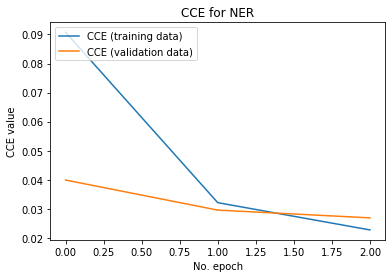

In [72]:
# Plot history: Categorical CrossEntropy(CCE)
plt.plot(history.history['loss'], label='CCE (training data)')
plt.plot(history.history['val_loss'], label='CCE (validation data)')

plt.title('CCE for NER')
plt.ylabel('CCE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

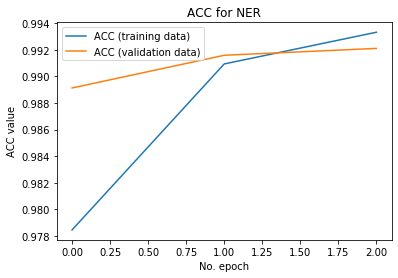

In [73]:
# Plot history: Accuracy(CCE)
plt.plot(history.history['accuracy'], label='ACC (training data)')
plt.plot(history.history['val_accuracy'], label='ACC (validation data)')

plt.title('ACC for NER')
plt.ylabel('ACC value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()